<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/GenerativeAI/WordEmbedding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

A computer model that has no experience of the real world can have no sense of the "meaning" of most words. So how can it possibly work with language in any kind of convincing way -- as so many models do today?

One piece to the puzzle is that a pretty rich *representation* of a word's meaning can be inferred purely from its associations with other words. A model may have no idea of what a cat actually is, but it can learn that a "cat" is a "small" "furry" "mammal" with "big eyes"; that "people" think "cats" are "cute" and often have them as "pets"; that many "cats" are "tabby", "tortoiseshell", or "orange". A model can learn all this about "cats" from processing text in which the word appears, in encyclopedias, social media posts, fiction, etc. And it can do this while having no idea what any of these other words means, either. It needs only relate these words to one another, not to any ground truth.

A model can learn grammar in a similar way. It can learn that the word "cat" appears in a similar pattern within sentences to other nouns like "dog" or "lamp" and dissimilarly to non-nouns like "launching" or "stelliferous", without ever being taught what a noun or a verb or an adjective is.

In this way, a model can build up a big map of the associations between words based on textual training data. It turns out that this is enough to let models parse, manipulate, and generate language in a way that often -- and increasingly -- emulates genuine understanding.

In this notebook, we'll explore a concrete, rudimentary example of a model doing exactly this.

In [ ]:
#@title <sub><sup>**Setup cell**
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import numpy as np

# A Simple Word Embedding Model

## Tarzan Language

For this notebook, we'll construct a toy language with just 27 words; 13 nouns, 9 verbs, 5 adjectives, and "will". Our nouns and adjectives come in categories, and we'll generate sentences using simple templates based on those categories:

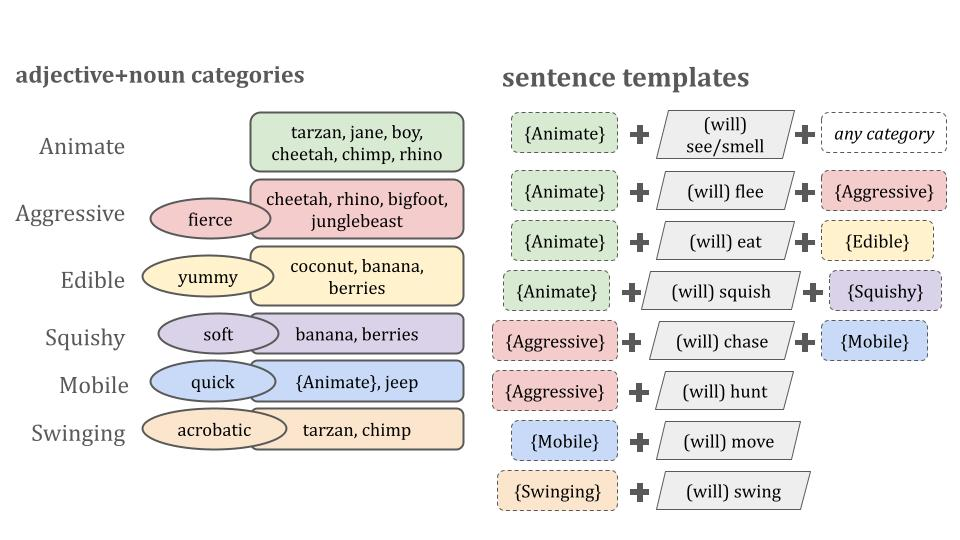

<sup>This toy language was based on one devised by Blank et al. [1]

In [ ]:
#@title <sub><sup>**Run this cell to load our language into Python**

categories = {
    "NOUN-ANIMATE": ["tarzan", "jane", "boy", "cheetah", "chimp", "rhino"],
    "NOUN-AGGRESS": ["cheetah", "rhino", "bigfoot", "junglebeast"],
    "NOUN-EDIBLE": ["coconut", "banana", "berries"],
    "NOUN-SQUISH": ["banana", "berries"],
    "NOUN-MOBILE": ["tarzan", "jane", "boy", "cheetah", "chimp", "rhino", "bigfoot", "junglebeast", "jeep"],
    "NOUN-SWING": ["tarzan", "chimp"],
    "NOUN": ["tarzan", "jane", "boy", "cheetah", "chimp", "rhino", "bigfoot", "junglebeast", "coconut", "banana", "berries", "jeep"],
    "ADJECTIVE-ANIMATE": [],
    "ADJECTIVE-AGGRESS": ["fierce"],
    "ADJECTIVE-EDIBLE": ["yummy"],
    "ADJECTIVE-SQUISH": ["soft"],
    "ADJECTIVE-MOBILE": ["quick"],
    "ADJECTIVE-SWING": ["acrobatic"],
    "ADJECTIVE": [],
    "TENSE": ["will"],
    "DET": [],
    "VERB-FLEE": ["flee"],
    "VERB-HUNT": ["hunt"],
    "VERB-AGGRESS": ["chase"],
    "VERB-SQUISH": ["squish"],
    "VERB-MOVE": ["move"],
    "VERB-EAT": ["eat"],
    "VERB-PERCEIVE": ["see", "smell"],
    "VERB-SWING": ["swing"]
}

templates = [
    ("NOUN-ANIMATE", "VERB-PERCEIVE", "NOUN"),
    ("NOUN-ANIMATE", "VERB-FLEE", "NOUN-AGGRESS"),
    ("NOUN-ANIMATE", "VERB-EAT", "NOUN-EDIBLE"),
    ("NOUN-ANIMATE", "VERB-SQUISH", "NOUN-SQUISH"),
    ("NOUN-AGGRESS", "VERB-AGGRESS", "NOUN-MOBILE"),
    ("NOUN-AGGRESS", "VERB-HUNT"),
    ("NOUN-MOBILE", "VERB-MOVE"),
    ("NOUN-SWING", "VERB-SWING"),
    ("NOUN-SWING", "VERB-EAT")
]

all_words = []
for cat in categories.keys():
  for word in categories[cat]:
    if word not in all_words:
      all_words.append(word)
print(len(all_words), 'words in all_words.')

27 words in all_words.


Now, let's generate a bunch of sentences in Tarzan Language using the sentence templates described above. This will be the text our model will learn from.

In [ ]:
#@title <sub><sup>**Run this cell to generate example sentences:**
sentences = []
for template in templates:
  word0_choices = categories[template[0]]
  word0_adjchoices = [""] + categories["ADJECTIVE" + template[0][4:]]
  word1_choices = categories[template[1]]
  word1_tensechoices = [""] + categories["TENSE"]
  word2_choices = [""]
  word2_adjchoices = [""]
  if len(template) == 3:
    word2_choices = categories[template[2]]
    word2_adjchoices = [""] + categories["ADJECTIVE" + template[2][4:]]
  for word0_adj in word0_adjchoices:
    for word0 in word0_choices:
      for word1_tense in word1_tensechoices:
        for word1 in word1_choices:
          for word2_adj in word2_adjchoices:
            for word2 in word2_choices:
              if word2 != word0:
                sentence = [word0_adj, word0, word1_tense, word1, word2_adj, word2]
                sentence = [word for word in sentence if word != '']
                sentences.append(sentence)
n_examples = 30
print('Generated', len(sentences), 'sentences.', 'Here are', n_examples, 'examples:')
for i in range(n_examples):
  sentence = random.choice(sentences)
  print('\t', end='')
  for word in sentence:
    print(word, end=' ')
  print('')

Generated 796 sentences. Here are 30 examples:
	chimp see berries 
	fierce cheetah chase bigfoot 
	boy smell bigfoot 
	junglebeast will chase quick rhino 
	chimp see cheetah 
	chimp flee bigfoot 
	cheetah will chase boy 
	tarzan see bigfoot 
	fierce rhino will chase jeep 
	jane will see rhino 
	jane will see jeep 
	boy flee junglebeast 
	chimp smell rhino 
	boy will flee bigfoot 
	tarzan see boy 
	fierce cheetah chase jeep 
	rhino will eat berries 
	cheetah will see jeep 
	jane squish soft banana 
	cheetah chase boy 
	rhino will eat yummy coconut 
	jane squish banana 
	jane will squish soft berries 
	junglebeast chase quick jane 
	junglebeast will chase quick rhino 
	jane will squish soft berries 
	boy flee cheetah 
	chimp will smell banana 
	jane will smell cheetah 
	fierce bigfoot will hunt 


You can run the cell above again to see different example sentences.

## Language into Numbers
Computers work with numbers; so in order to process text, programmers define discrete chunks of text -- called "tokens" -- and represent each numerically. In our case, our tokens will just be the 27 words of our language. To begin with, we just associate each token with a unique integer:

In [ ]:
vocab = {}
for i, word in enumerate(all_words):
  vocab[word] = i
print(vocab)
vocab_size = len(all_words)

{'tarzan': 0, 'jane': 1, 'boy': 2, 'cheetah': 3, 'chimp': 4, 'rhino': 5, 'bigfoot': 6, 'junglebeast': 7, 'coconut': 8, 'banana': 9, 'berries': 10, 'jeep': 11, 'fierce': 12, 'yummy': 13, 'soft': 14, 'quick': 15, 'acrobatic': 16, 'will': 17, 'flee': 18, 'hunt': 19, 'chase': 20, 'squish': 21, 'move': 22, 'eat': 23, 'see': 24, 'smell': 25, 'swing': 26}


The words "tarzan", "bigfoot", "soft", for example, map to the numbers 0, 6, and 14 respectively.

However, integers by themselves can't represent the relationships that we eventually want to model. We'll need to translate these integers into a richer format.

All models today use *n*-dimensional vectors to represent tokens internally. These vector representations are called **embeddings**. You can think of an embedding as a point in *n*-dimensional space. The arrangement of different embeddings in this space is how models represent relationships between words. With higher dimensional spaces (GPT4 uses 12288 dimensions), very complex relationships can be represented.

But how do you come up with these embeddings in the first place? Where in *n*-D space should the "dog" go, and where should "cat" be situated in relation to it?

Modern language models generate embeddings internally, tweaking them as they train. But there are also algorithms whose entire job is to arrange embeddings based on text. The word2vec model, introduced by Mikolov et al. [3], is one such algorithm.

## Introducing word2vec

The word2vec algorithm is simple: if words appear often next to one another, word2vec pushes their embeddings closer together; if they rarely or never appear together, it pushes their embeddings farther apart.

**But how does this capture semantic closeness?** After all, semantically similar words might rarely appear together. "torch" and "lamp" refer to similar objects, but you don't see "torch lamp" often in text.

One mechanism to consider is that similar words will often co-occur with a similar set of other words. For example, both "torch" and "lamp" may occur frequently next to "bright" ("the bright lamp", "the bright torch"). Then, as word2vec pushes the embeddings for "lamp" and "torch" closer to the embedding for "bright", it indirectly pushes them closer to one another.



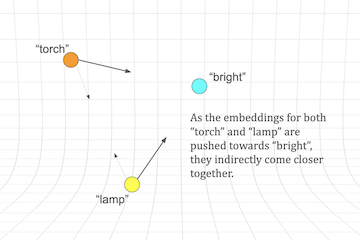

**We'll be building a modified version of word2vec**&ast;, based on a common word embedding scheme called the **skip-gram**. To train the model, we create a dataset consisting of *positive* and *negative samples*. Positive samples are pairs of words that appear next to one another in a sentence. We generate these by fixing each word as a "target word", and finding its "context words" -- the words that appear next to it -- to form pairs. Consider the sentence ['boy', 'squish', 'soft', 'banana']. With target words 'boy', and 'squish', we get:

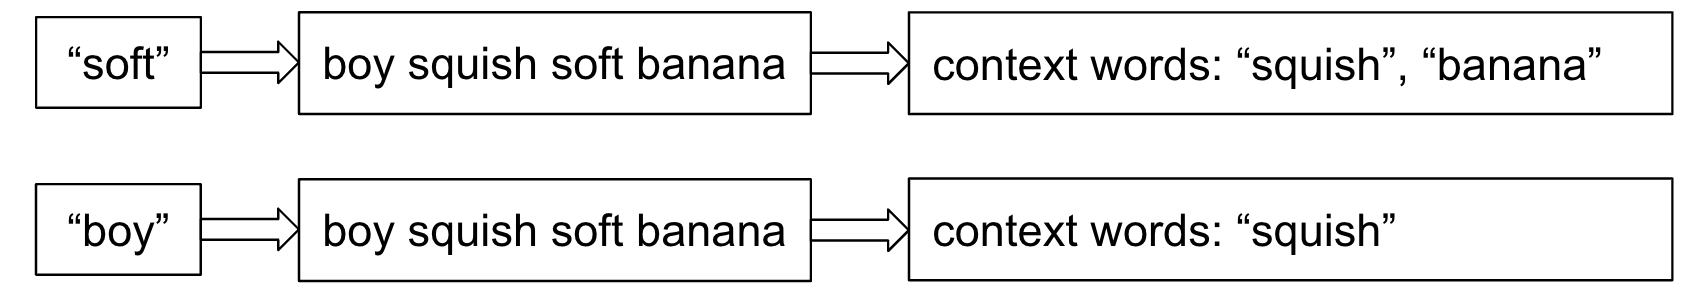

Let's generate our positive samples. We'll go through all our sentences and, treating each word as a target word, find all its context words to form pairs.

<details><summary>Why do it this way?</summary>

<sub><sup>You may notice that the way we're forming pairs is equivalent to just forming all pairs of adjacent words, except twice each. So why all this with "target" and "context" words?

<sub><sup>We're doing this to follow the framework of the original word2vec algorithm, which A) has a customizable "context window" size so that valid "context" words can be more than 1 word away from the "target" word; and B) produces *two* distinct embeddings per word, one for when it is the target word in a sample, and one for when it is the context word, so that the distinction actually matters.

<sub><sup>You may also notice that this approach produces a ton of duplicate pairs. This is also intentional: we want our model to train more often on the pairs that appear more frequently in the training text, in order to capture a stronger association.</details>

In [ ]:
positive_samples = []
rand_idx = random.randint(0, len(sentences)-1)
for i, sentence in enumerate(sentences):
  samples_from_sentence = []
  for j in range(len(sentence)):
    if j > 0:
      samples_from_sentence.append((sentence[j], sentence[j-1]))
    if j < len(sentence) - 1:
      samples_from_sentence.append((sentence[j], sentence[j+1]))
  if i == rand_idx:
    print('Example sentence:', sentence, '\tPositive samples from sentence:', samples_from_sentence)
  positive_samples = positive_samples + samples_from_sentence
print('\nGenerated', len(positive_samples), 'positive samples total. Here are 10:', [random.choice(positive_samples) for i in range(10)])

Example sentence: ['tarzan', 'will', 'eat', 'coconut'] 	Positive samples from sentence: [('tarzan', 'will'), ('will', 'tarzan'), ('will', 'eat'), ('eat', 'will'), ('eat', 'coconut'), ('coconut', 'eat')]

Generated 4632 positive samples total. Here are 10: [('chase', 'will'), ('jane', 'smell'), ('will', 'chase'), ('will', 'eat'), ('junglebeast', 'fierce'), ('smell', 'banana'), ('berries', 'yummy'), ('yummy', 'eat'), ('will', 'bigfoot'), ('chase', 'quick')]


We also need to generate negative samples, pairs of words that do not appear next to each other in any sentence. They are basically fake samples where the target word is mapped to fake "context words".

Example training set for the target word "soft":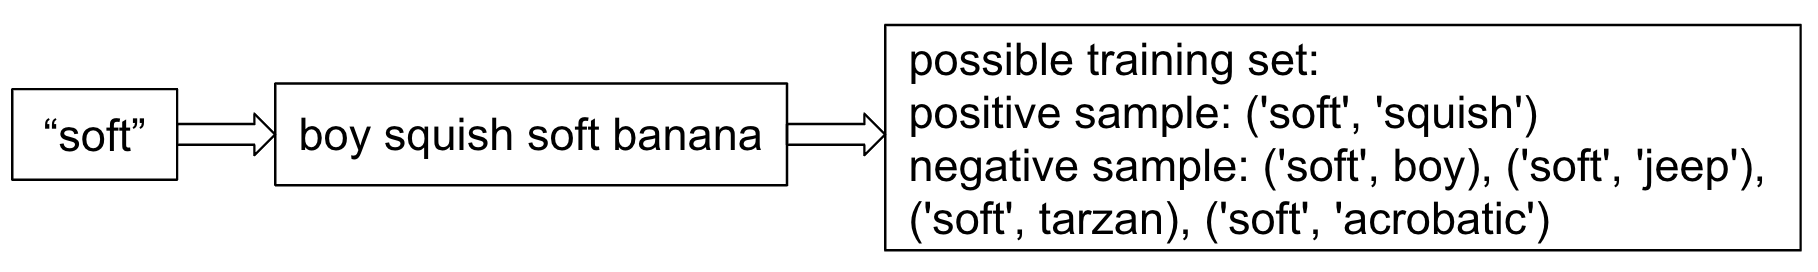

Since our training text has such a small vocabulary, we can find and include all pairs of words that aren't in the positive samples. (This wouldn't be practical on real texts with large vocabularies, where the usual approach is instead to generate a fixed number of negative samples, say 5, for each positive sample).

In [ ]:
negative_samples = []
for i in range(len(all_words)-1):
  for j in range(i+1, len(all_words)):
    word1 = all_words[i]
    word2 = all_words[j]
    if (word1, word2) not in positive_samples and (word2, word1) not in positive_samples:
      negative_samples.append((word1, word2))
for ns in negative_samples: # Sanity check
  assert ns not in positive_samples
print('Generated', len(negative_samples), 'negative samples total. Here are 10:', [random.choice(negative_samples) for i in range(10)])

Generated 236 negative samples total. Here are 10: [('banana', 'swing'), ('hunt', 'swing'), ('berries', 'swing'), ('berries', 'will'), ('yummy', 'smell'), ('yummy', 'flee'), ('jane', 'junglebeast'), ('boy', 'banana'), ('tarzan', 'berries'), ('fierce', 'yummy')]


Our model's job is binary classification: it'll be trained to guess whether a given sample is positive or negative. Our model does this by calculating the distance between the two word's embeddings. If their distance falls below some learnable threshold, then the model predicts that this sample is positive. Otherwise, it predicts that it is negative.

<details><summary>Why Euclidean distance?</summary>

<sub><sup>The actual word2vec algorithms use the dot product of embeddings, not Euclidean distance as we're doing. Using dot product results in more useful embeddings with nicer properties for real-world applications (e.g. resulting in useful subspaces). Using dot product also removes the need for the learnable threshold term, which is therefore not part of the standard word2vec algorithm.

<sub><sup>However, we're using distance because it's more immediately intuitive (for people without a linear algebra background), and also because it produces better visualizations.
</details>

The model then adjusts their embeddings depending on whether it gave the right answer. If it predicted a false positive (i.e. it guessed positive for a negative sample), then the two embeddings were too close together, and the model adjusts them to be farther apart. And vice versa: if it predicted a false negative (it guessed negative for a positive sample), the embeddings are pushed closer together.

A diagram illustrating what our model will do given a sample in training:



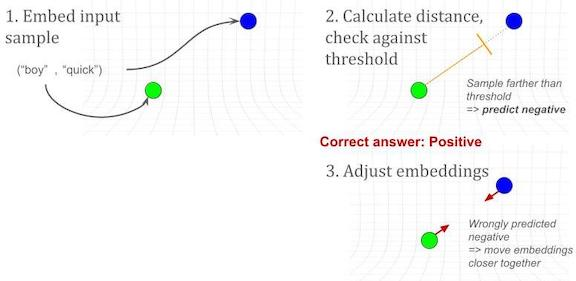

**What we ultimately want is different from what we're training the model to do.** We don't actually care about how good the model is at classifying positive vs negative pairs; it's a proxy task that leads the model to arrange the embeddings in the way we described. After training, we'll simply extract the embeddings that the model has learned and evaluate them directly.

## Preparing for Training

Let's initialize our model. It'll start with random embeddings for each word.

In [ ]:
import torch
class Word2Vec(torch.nn.Module):
  def __init__(self, vocab_size, d_embed):
    super().__init__()
    # This module holds all the adjustable embeddings.
    self.embedder = torch.nn.Embedding(vocab_size, d_embed)
    # This is the learnable threshold value.
    self.threshold = torch.nn.Parameter(torch.tensor([1.0]))
    # We use the sigmoid function as our output function, to
    # squeeze the output to between 0 and 1.
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, X):
    # Fetch the embedding of the first word in the pair:
    target_embeds = self.embedder(X[:, 0])
    # Fetch the embedding of the second word:
    context_embeds = self.embedder(X[:, 1])
    # Calculate the distance between them (Euclidean):
    dists = torch.linalg.vector_norm(target_embeds - context_embeds, 2, dim=-1)
    # Determine whether the distance is below the threshold:
    output = self.sigmoid(self.threshold - dists)
    return output

  def get_embedding(self, integer):
    # Output the embedding of a given word (from its integer):
    return self.embedder(integer)
# Initialize our model with an embedding dimension of 32:
model = Word2Vec(vocab_size, 32)

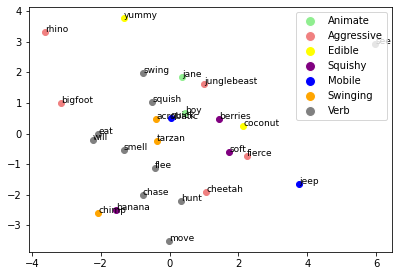

In [ ]:
#@title <sub><sup>**Run this cell to show a plot of the initial embeddings**
def get_dist_of_words(word1, word2):
  return torch.norm(get_embedding_of_word(word1) - get_embedding_of_word(word2), 2)
def get_embedding_of_word(word):
  tensor = torch.IntTensor([vocab[word]])
  embed = model.get_embedding(tensor)
  return embed
initial_embeddings_list = []
words = all_words
for word in words:
  embedding = get_embedding_of_word(word)[0].detach().numpy()
  initial_embeddings_list.append(embedding)

def plot_embeddings(ls):
  # Put each word inside one category
  category_dict = {'jane': 'Animate', 'boy': 'Animate',
                   'bigfoot': 'Aggressive', 'junglebeast': 'Aggressive', 'rhino': 'Aggressive', 'cheetah': 'Aggressive', 'fierce': 'Aggressive',
                   'coconut': 'Edible','yummy': 'Edible',
                   'banana': 'Squishy','berries': 'Squishy','soft': 'Squishy',
                   'jeep': 'Mobile','quick': 'Mobile',
                   'tarzan': 'Swinging','chimp': 'Swinging','acrobatic': 'Swinging',
                   'see': 'Verb','smell': 'Verb','flee': 'Verb','eat': 'Verb','squish': 'Verb','chase': 'Verb','hunt': 'Verb','move': 'Verb','swing': 'Verb','will' : 'Verb'
  }
  # Pick a color for each category
  category_colors = {'Animate': 'lightgreen','Aggressive': 'lightcoral','Edible': 'yellow','Squishy': 'purple','Mobile': 'blue','Swinging': 'orange','Verb': 'gray'}
  pca = PCA(n_components=2)
  reduced_embeddings = pca.fit_transform(ls)
  # Scatter plot
  plt.figure(figsize=(6.5, 4.5))
  for word, index in vocab.items():
      category = category_dict.get(word)
      color = category_colors.get(category)
      plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1], color=color, label=category)
      plt.annotate(word, xy=(reduced_embeddings[index, 0], reduced_embeddings[index, 1]), fontsize=9)
  # Legend
  handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=category_colors[temp], markersize=10) for temp in category_colors]
  plt.legend(handles, category_colors.keys(), loc='upper right')
  plt.show()

plot_embeddings(initial_embeddings_list)

The above is a PCA projection, a method for reducing high dimensional data. In our case, we've reduced our model's 32-dimensional embeddings to 2D so that we can visualize them. Information is always lost this way, but it does give us a glimpse into how the model has arranged them. Right now, as the projection shows, it hasn't done any arranging.

With our positive and negative samples ready, we can combine them into a training set to train our model. We'll duplicate the negative samples so there are roughly two negative samples per positive sample. We'll also bundle each sample with its correct label -- 1 for positive, 0 for negative -- for the training process.

In [ ]:
trainset = [(ps, 1) for ps in positive_samples] + 2*(len(positive_samples) // len(negative_samples))*[(ns, 0) for ns in negative_samples]
random.shuffle(trainset)
print(len(trainset), 'training samples total. Here are 10:', [random.choice(trainset) for i in range(10)])

13600 training samples total. Here are 10: [(('rhino', 'quick'), 1), (('yummy', 'flee'), 0), (('will', 'chase'), 1), (('yummy', 'will'), 0), (('boy', 'fierce'), 0), (('quick', 'hunt'), 0), (('squish', 'soft'), 1), (('banana', 'fierce'), 0), (('will', 'squish'), 1), (('soft', 'acrobatic'), 0)]


## Training our Model

Let's define our gradient descent algorithm and our loss function. We're using Binary Cross-Entropy Loss, which is standard for binary classification tasks.

In [ ]:
optim = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

Now let's train our model. Since our trainset is so small, we can input and train on the entire trainset at once. The loop below runs for 2500 epochs, and should take about 2 minutes.

In [ ]:
for epoch in range(2500):
  random.shuffle(trainset)

  optim.zero_grad()
  pairs = [[vocab[sample[0][0]], vocab[sample[0][1]]] for sample in trainset]
  pairTensor = torch.IntTensor(pairs)
  labels = [sample[1] for sample in trainset]
  labelTensor = torch.FloatTensor(labels)

  output = model(pairTensor)
  loss = loss_fn(output, labelTensor)
  loss.backward()

  optim.step()
  if epoch == 0 or (epoch+1) % 500 == 0:
    print("Epoch", epoch, "\tTraining Loss:", loss.item())

Epoch 0 	Training Loss: 2.412036180496216
Epoch 499 	Training Loss: 1.249761700630188
Epoch 999 	Training Loss: 0.5969582200050354
Epoch 1499 	Training Loss: 0.3950635492801666
Epoch 1999 	Training Loss: 0.3410216271877289
Epoch 2499 	Training Loss: 0.322725772857666


## Exploring our Embeddings
Now that our model has been trained, let's collect its embeddings to explore how it has arranged them.

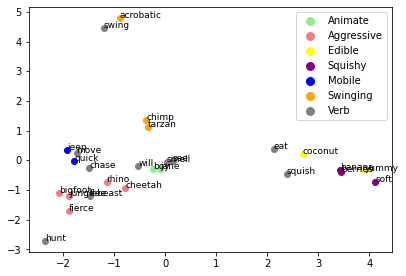

In [ ]:
embeddings = {}
embeddings_list = []
for word in all_words:
  embedding = get_embedding_of_word(word)[0].detach().numpy()
  embeddings[word] = embedding
  embeddings_list.append(embedding)
plot_embeddings(embeddings_list)

Compare this plot to the plot of the initial embeddings. What do you see? Do you notice anything you expected, or did not expect?

For instance, do you notice that words of the same semantic category (e.g. "soft" "banana" and "berries") have clustered together?

Some of the words were put in multiple categories. For instance, "cheetah" belongs in both "animate" and "aggressive", versus "junglebeast" which belongs only in "aggressive". Do their embeddings differ noticeably?

Remember that this is a PCA projection, so it won't represent our 32-dimensional embeddings perfectly. Embeddings that might plot very close by, like "chimp" and "tarzan", may not actually be each other's nearest neighbors. Test this out in the cell below!

In [ ]:
#@title <sub><sup>**Run this cell to find a word's three nearest neighbors**
def get_nearest_neighbors(target_word, embedding_dict, n=3):
  target_embed = embedding_dict[target_word]
  top_n = [('<placeholder>', 999) for i in range(n)]
  for word in embedding_dict:
    if word != target_word:
      dist = np.linalg.norm(target_embed - embedding_dict[word], ord=2)
      for i in range(len(top_n)):
        if dist < top_n[i][1]:
          top_n.insert(i, (word, dist))
          del top_n[-1]
          break
  return top_n
word = input("> ")
if word in all_words:
  print('Here are "' + word + '"\'s nearest neighbors: ' + str(get_nearest_neighbors(word, embeddings)))
else:
  print('Sorry,', word, 'is not in the vocabulary.')

>  tarzan


Here are "tarzan"'s nearest neighbors: [('see', 1.9153484), ('smell', 1.9285969), ('will', 2.037571)]


What do you notice? Do the words have the nearest neighbors you'd expect? If you notice any unexpected neighbors, thinking back to our generated text, can you explain why their embeddings might have been placed close together?

For instance, "aggressive" nouns like "bigfoot" may end up near neighbors with "flee". Why might that be? Try the word "will". Are its neighbors as you'd expect? Try a verb like "squish" as well.

In [ ]:
#@title <sub><sup>**Run this cell to compare embeddings between words**
def get_pair_distance(word1, word2, embedding_dict):
  word1_embed = embedding_dict[word1]
  word2_embed = embedding_dict[word2]
  return np.linalg.norm(word1_embed - word2_embed, ord=2)
print('Enter two words to compare their embeddings.')
word1 = input(' Word 1 > ')
word2 = input(' Word 2 > ')
if word1 in all_words and word2 in all_words:
  print('Distance between "' + word1 + '" and "' + word2 + '"\'s embeddings: ' + str(get_pair_distance(word1, word2, embeddings)))
elif word1 not in all_words:
  print('Sorry,', word1, 'is not in the vocabulary.')
else:
  print('Sorry,', word2, 'is not in the vocabulary.')

Enter two words to compare their embeddings.


 Word 1 >  berries
 Word 2 >  soft


Distance between "berries" and "soft"'s embeddings: 2.2808504


Try comparing different pairs of words, or comparing the distances of three words. Are the results as you'd expect?

## Conclusion

We started this notebook by asking how language models with no experience of the real world can learn to represent the meanings of words. We then built and trained a simple example of a model doing exactly that -- albeit from training on our made-up Tarzan Language.

So how do word embedding algorithms fare on real text from real language?

# Exploring word2vec 10k

Now let's take a look at word embeddings generated in the real world. Check out this website which visualizes embeddings produced by a word2vec model that was fed a far larger dataset of real English texts, showing 10k of the most frequent words: https://projector.tensorflow.org/

You can click on an embedding in the graph or search for specific words, and see its nearest neighbors. Are they as you'd expect? What links these words (if anything)? do they mean similar things? Do they have similar connotations? Are they grammatically similar? Do they rhyme?

<details>

<sub><sup>Note that with the larger dataset of real language (not our simplified toy language), and the higher embedding dimension (200), these embeddings capture far more complex relationships -- that are even further obscured by the 3D PCA projection.

<sub><sup>For instance, certain "directions" in the embedding space may emerge that express "degrees" of some semantic meaning, like a "gender" direction or a temporal direction. Similarly, subspaces may emerge encompassing certain words with something in common, like a subspace for verbs in particular.</details>

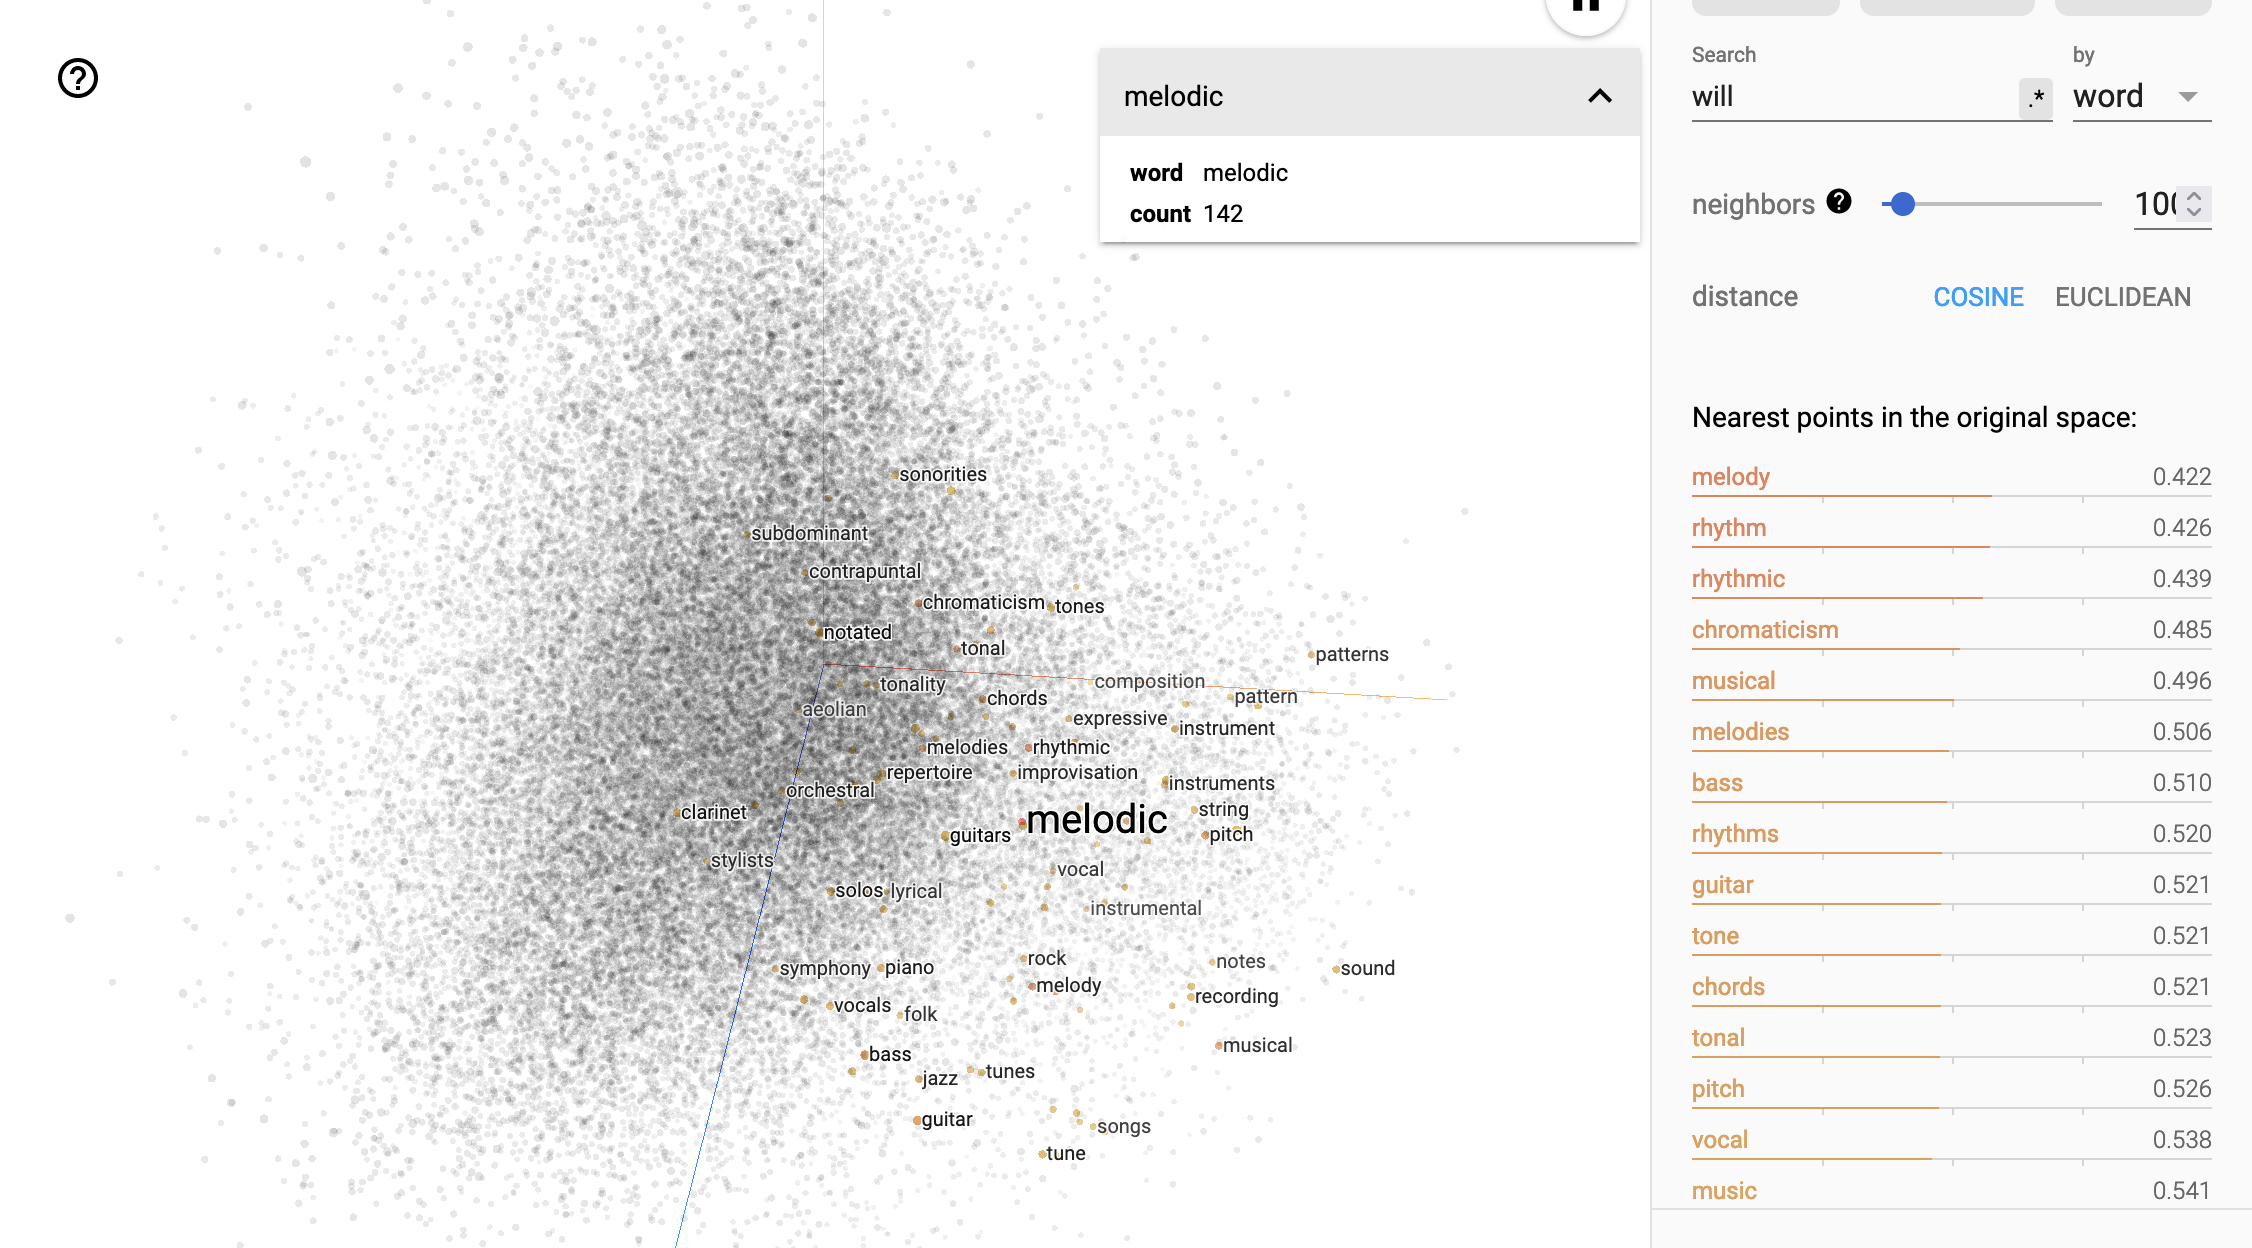

# Learning Bias
So we've seen that word embedding algorithms like word2vec do an impressive job of learning to represent the "meanings" of words from their associations with other words in text. But what happens when some of those associations are problematic, biased, or prejudicial?

In July 2016, Bolukbasi et al. published [Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](https://arxiv.org/pdf/1607.06520) [2]. In the paper they inspect the embeddings produced by w2vNEWS, a word2vec model which was trained on thousands of Google News articles. Using several different techniques, they exposed how inappropriate gender stereotypes were encoded in these embeddings.

For example, they projected dozens of embeddings onto the *she*-*he* axis -- the line connecting the embedding for "she" to the embedding for "he" -- to see where they lay. Some definitionally gendered words, like *sisters* or *boyhood*, were situated as expected, nearer to *she* and *he* respectively. However, many words that are not definitionally gendered were also skewed towards one or the other. For example, *homemaker*, *nurse*, and *beautiful* were significantly closer to *she*; while *genius*, *command*, and *philosopher* were closer to *he*.

They also analyzed directions in the embedding space to find gendered pairs of words. By subtracting the embeddings *woman-man* to approximate a "male-to-female step" in the embedding space, they found for example that *king + (woman-man)* landed very near to the embedding *queen*, as expected. But troublingly, *computer_programmer + (woman-man)* landed near *homemaker*, and *comical + (woman-man)* landed near *hysterical*. The full paper lists hundreds of these pairs, some more problematic than others.

This isn't surprising. A word embedding algorithm's job is to extract all the associations they can from what they're fed. They aren't equipped to determine whether those associations should be learned in the first place. w2vNEWS' problematic embeddings only reflect problematic associations present (however subtly) in the news articles it was trained on. Word embeddings are a black mirror.

In w2vNEWS' case, this wasn't irreparable: the paper itself outlines how they successfully managed to remove these biases from the w2vNEWS embeddings while preserving their general usefulness. But this problem of bias isn't restricted to word embeddings. All language models pick up on the associations in the language they're trained on, and trying to rectify them, when it comes to large models like GPT-4 -- which are *far* more complex than word2vec, and comparatively poorly understood -- remains an open area of research.

# References

[1]	D. S. Blank, L. A. Meeden, and J. B. Marshall, ‘Exploring the symbolic/subsymbolic continuum: A case study of RAAM’, in The Symbolic and Connectionist Paradigms, Psychology Press, 2014, pp. 113–148.

[2]	T. Bolukbasi, K.-W. Chang, J. Zou, V. Saligrama, and A. Kalai, ‘Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings’, arXiv [cs.CL]. 2016.

[3]	T. Mikolov, K. Chen, G. Corrado, and J. Dean, ‘Efficient Estimation of Word Representations in Vector Space’, arXiv [cs.CL]. 2013.